In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

In [ ]:
def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [ ]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(3500, 784)
trainTarget = trainTarget.reshape(3500, 1)
validData = validData.reshape(100, 784)
validTarget = validTarget.reshape(100, 1)
testData = testData.reshape(145, 784)
testTarget = testTarget.reshape(145, 1)

In [ ]:
def loss(w, b, x, y, reg):
    z = np.matmul(x, w) + b
    N = x.shape[0]
    #Lce = -y * np.log(yhat) - (np.ones((N,1))-y) * np.log(np.ones((N,1)) - yhat)
    Lce = z + np.log(1+np.exp(-z)) - y*z
    Lce = np.mean(Lce)
    Lw = (reg/2) * np.square(np.linalg.norm(w))
    return Lce + Lw

In [ ]:
def grad_loss(w, b, x, y, reg):
    z = np.matmul(x, w) + b
    yhat = 1/(1+np.exp(-z))
    N, d = x.shape

    grad_b = np.mean(yhat-y)
    grad_w_CE = np.reshape((np.sum((yhat-y) * x, axis=0)/N), (d,1))
    grad_w_reg = reg*w
    grad_w = grad_w_CE + grad_w_reg
    return grad_w, grad_b

In [ ]:
def grad_descent(W, b, x, y, x_val, y_val, alpha, epochs, reg, error_tol=0.0000001):
    N, d = x.shape
    loss_graph = []
    accuracy_graph = []
    loss_graph_valid = []
    accuracy_graph_valid = []

    for i in range(epochs):
        train_loss = loss(W, b, x, y, reg)
        valid_loss = loss(W, b, x_val, y_val, reg)
        loss_graph.append(train_loss)
        loss_graph_valid.append(valid_loss)

        z = np.matmul(x, W) + b
        yhat = 1/(1+np.exp(-z))
        yhat = np.where(yhat > 0.5, 1, 0)
        train_acc = np.mean(y == yhat)
        accuracy_graph.append(train_acc)

        z_valid = np.matmul(x_val, W) + b
        yhat_valid = 1/(1+np.exp(-(z_valid)))
        yhat_valid = np.where(yhat_valid > 0.5, 1, 0)
        valid_acc = np.mean(y_val == yhat_valid)
        accuracy_graph_valid.append(valid_acc)

        if i % 50 == 0:
            print('current loss is:', train_loss)

        gradient_w, gradient_b = grad_loss(W, b, x, y, reg)
        W_new = W - alpha * gradient_w
        b_new = b - alpha * gradient_b

        if np.linalg.norm(W_new - W) < error_tol:
            break
        else:
            W = W_new
            b = b_new
        
    plt.title("Loss vs Epoch")
    plt.plot(loss_graph, label = 'train')
    plt.plot(loss_graph_valid, label = 'validation')
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy vs Epoch")
    plt.plot(accuracy_graph, label = 'train')
    plt.plot(accuracy_graph_valid, label = 'validation')
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    return W, b

current loss is: 39.38962632309166
current loss is: 36.50764493193949
current loss is: 34.39238081669405
current loss is: 32.531949135989535
current loss is: 30.831589525496305
current loss is: 29.252759433920133
current loss is: 27.774009344427704
current loss is: 26.38186552461276
current loss is: 25.067238762890312
current loss is: 23.823396276125465
current loss is: 22.644983865748816
current loss is: 21.527541886553006
current loss is: 20.46723174174979
current loss is: 19.460663643574506
current loss is: 18.504784477900806
current loss is: 17.596804629604573
current loss is: 16.73414941690746
current loss is: 15.914425640833331
current loss is: 15.135397494494363
current loss is: 14.394968454764415
current loss is: 13.691167143466712
current loss is: 13.02213591929061
current loss is: 12.386121413760682
current loss is: 11.78146649785915
current loss is: 11.206603335488653
current loss is: 10.660047287099312
current loss is: 10.140391495453095
current loss is: 9.646302030200921
c

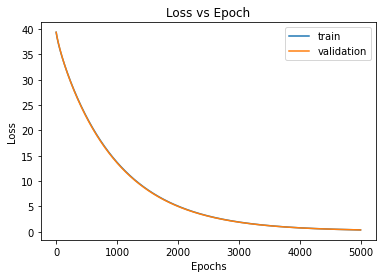

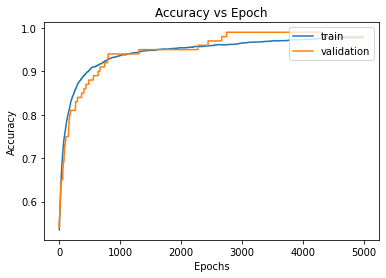

In [ ]:
np.random.seed(6)
W_init = np.random.standard_normal((784,1))
b_init = 0
w_final, b_final  = grad_descent(W_init, b_init, trainData, trainTarget,validData, validTarget, 0.005, 5000, 0.1, 0.0000001)

In [ ]:
def buildGraph(lr=0.001, b1=0.9, b2=0.999, eps=1e-08):
    tf.set_random_seed(1)
    b = tf.Variable(tf.zeros([1]))
    w = tf.Variable(tf.random.truncated_normal(shape=[784,1], mean=0, stddev=0.5))

    reg = tf.placeholder(tf.float32)
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)

    logit = tf.tensordot(x,w,axes=1) + b
    pred = tf.sigmoid(logit)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=y)) + (reg/2)*tf.norm(w)
    optimiser = tf.train.AdamOptimizer(learning_rate=0.001, beta1=b1, beta2=b2, epsilon=eps)

    return w, b, pred, x, y, loss, optimiser, reg

In [ ]:
def sgd(x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size, reg_feed):

    x_train = x_train.astype('float')
    y_train = y_train.astype('float')

    w, b, pred, x, y, loss, opt, reg = buildGraph(eps=1e-4)
    train = opt.minimize(loss)
    N = x_train.shape[0]
    d = x_train.shape[1]

    accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_float(pred > 0.5), tf.to_float(y))))

    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession() #so that I can just use .eval()
    sess.run(init)

    trainLoss = np.array([])
    validLoss = np.array([])
    testLoss = np.array([])
    xLoss = np.array([])
    train_acc = np.array([])
    valid_acc = np.array([])
    test_acc = np.array([])
    finalw = w.eval()
    finalb = b.eval()
    highestAcc = 0

    iterPerEpochs = math.floor(N/batch_size)

    for epoch in range(epochs):

        shuffled = np.concatenate((x_train, y_train), axis=1)
        np.random.shuffle(shuffled)

        for i in range(iterPerEpochs):
            X = shuffled[i*batch_size:(i+1)*batch_size, :d]
            Y = shuffled[i*batch_size:(i+1)*batch_size, d].reshape(batch_size, 1)

            if ((epoch*iterPerEpochs + i) % 10 == 0):
                train_acc = np.append(train_acc, accuracy.eval(feed_dict={x: x_train, y: y_train, reg: reg_feed}))
                valid_acc = np.append(valid_acc, accuracy.eval(feed_dict={x: x_valid, y: y_valid, reg: reg_feed}))
                test_acc = np.append(test_acc, accuracy.eval(feed_dict={x: x_test, y: y_test, reg: reg_feed}))
                if (highestAcc < accuracy.eval(feed_dict={x: x_valid, y: y_valid, reg: reg_feed})):
                    finalw = w.eval()
                    finalb = b.eval()
                    highestAcc = accuracy.eval(feed_dict={x: x_valid, y: y_valid, reg: reg_feed})
                validLoss = np.append(validLoss, loss.eval(feed_dict={x: x_valid, y: y_valid, reg: reg_feed}))
                testLoss = np.append(testLoss, loss.eval(feed_dict={x: x_test, y: y_test, reg: reg_feed}))
            _, err, curw, curb, yHat = sess.run([train, loss, w, b, pred], feed_dict={x: X, y: Y, reg: reg_feed})

            if ((epoch*iterPerEpochs + i) % 10 == 0):
                print("epoch: ", epoch)
                print("step: ", (epoch*iterPerEpochs + i))
                print("loss: ", err)
                trainLoss = np.append(trainLoss, err)
                xLoss = np.append(xLoss, (epoch*iterPerEpochs + i))
    ftrain_acc = accuracy.eval(feed_dict={x: x_train, y: y_train, reg: reg_feed})
    fvalid_acc = accuracy.eval(feed_dict={x: x_valid, y: y_valid, reg: reg_feed})
    ftest_acc = accuracy.eval(feed_dict={x: x_test, y: y_test, reg: reg_feed})

    print("accuracy")
    print("train: ", ftrain_acc)
    print("valid: ", fvalid_acc)
    print("test: ", ftest_acc)

    return xLoss, trainLoss, validLoss, testLoss, train_acc, valid_acc, test_acc, finalw, finalb

In [ ]:
x, trainloss, validloss, testloss, train_acc, valid_acc, test_acc, finalw, finalb = sgd(trainData, trainTarget, validData, validTarget, testData, testTarget, 700, 500, 0)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch:  0
step:  0
loss:  2.584816
epoch:  1
step:  10
loss:  1.1972569
epoch:  2
step:  20
loss:  0.7356208
epoch:  4
step:  30
loss:  0.6145492
epoch:  5
step:  40
loss:  0.4363271
epoch:  7
step:  50
loss:  0.40636787
epoch:  8
step:  60
loss:  0.31602964
epoch:  10
step:  70
loss:  0.3058824
epoch:  11
step:  80
loss:  0.29545614
epoch:  12
step:  90
loss:  0.24639182
epoch:  14
step:  100
loss:  0.2858156
epoch:  15
step:  110
loss:  0.22887792
epoch:  17
step:  120
loss:  0.18558277
epoch:  18
step:  130
loss:  0.23496367
epoch:  20
step:  140
loss:  0.25724596
epoch:  21
step:  150
loss:  0.21449405
epoch:  22
step:  160
loss:  0.15544784
epoch:  24
step:  170
loss:  0.1927763
epoch:  25
step:  180
loss:  0.1355862
epoch:  27
step:  190
loss:  0.19041352
epoch:  28
step:  200
loss:  0.22446637
epoch:  30
step:  210
loss:  0.15483674
epoch:  31
step:  220
loss:  0.106812134
epoch:  32
step:  230
loss:  0.26347682
epoch:  34
step:  240
loss:  0.17324755
epoch:  35
step:  250
loss:

In [ ]:
def plot_3_datLoss(x, a, b, c, num):
    plt.figure(num)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.title('Performance Graph')
    green_patch = mpatches.Patch(color='green', label='Train Data')
    blue_patch = mpatches.Patch(color='blue', label='Valid Data')
    red_patch = mpatches.Patch(color='red', label='Test Data')
    plt.legend(handles=[green_patch, blue_patch, red_patch])

    plt.plot(x, a, 'g-', x, b, 'b-', x, c, 'r-')

def plot_3_datAcc(x, a, b, c, num):
    plt.figure(num)
    plt.xlabel('Number of Iterations')
    plt.ylabel('Acc')
    plt.title('Performance Graph')
    green_patch = mpatches.Patch(color='green', label='Train Data')
    blue_patch = mpatches.Patch(color='blue', label='Valid Data')
    red_patch = mpatches.Patch(color='red', label='Test Data')
    plt.legend(handles=[green_patch, blue_patch, red_patch])

    plt.plot(x, a, 'g-', x, b, 'b-', x, c, 'r-')

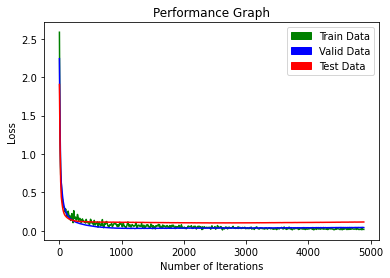

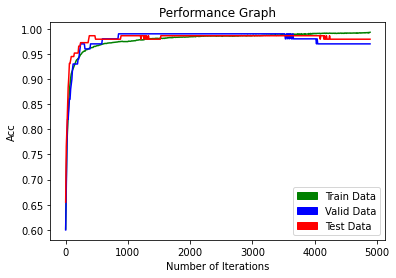

In [ ]:
plot_3_datLoss(x, trainloss, validloss, testloss, 1)
plot_3_datAcc(x, train_acc, valid_acc, test_acc, 2)